In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=e7b74745f8a8de867aac031594edee3c602dc2b3b351c16ff28ca0a857f34cf6
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import re
from langdetect import detect, DetectorFactory
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DetectorFactory.seed = 0

# Load unlabeled dataset
raw_input_path = '/content/drive/MyDrive/comments_unlabeled.jsonl'
data = []
with open(raw_input_path, 'r', encoding='utf-8') as f:
    for line in f:
        entry = json.loads(line)
        data.append(entry)

print(f"Total raw comments: {len(data)}")

Total raw comments: 4220


## Preprocessing Steps:

1. **Filtering Non-Text Content:** Remove entries with empty or whitespace-only `comment_text`.
2. **Basic Text Cleaning:** Normalize whitespace, remove HTML/Markdown artifacts and newlines.
3. **Filter English Comments:** Use `langdetect` to keep only comments detected as English.
4. **Compute Word and Character Lengths:** For EDA.
5. **Save Filtered Output:** Write to `filtered_comments.jsonl`.

In [5]:
# Preprocessing function
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace newlines with space
    text = text.replace('\n', ' ').strip()
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text

filtered_data = []
for entry in data:
    text = entry.get('comment_text', '').strip()
    # Filter out empty or non-text comments
    if not text:
        continue
    # Clean text
    cleaned = clean_text(text)
    if not cleaned:
        continue
    # Attempt language detection; skip if detection fails
    try:
        lang = detect(cleaned)
    except:
        continue
    if lang != 'en':
        continue
    # Compute lengths
    entry['cleaned_text'] = cleaned
    entry['word_len'] = len(cleaned.split())
    entry['char_len'] = len(cleaned)
    filtered_data.append(entry)

print(f"Filtered English comments: {len(filtered_data)}")

Filtered English comments: 3711


In [ ]:
df = pd.DataFrame(filtered_data)

# Check for NaNs 
nan_comments = df[df['cleaned_text'].isna()]
print(f"Number of NaN comments in 'cleaned_text': {len(nan_comments)}")

# Check for duplicate 
duplicate_comments = df[df.duplicated(subset=['cleaned_text'], keep=False)]
print(f"Number of duplicate comments (based on cleaned text): {len(duplicate_comments)}")


Number of NaN comments in 'cleaned_text': 0
Number of duplicate comments (based on cleaned text): 333


In [16]:
df = df.drop_duplicates(subset=['cleaned_text'])
print(f"Number of unique comments after dropping duplicates: {len(df)}")



Number of unique comments after dropping duplicates: 3539


In [17]:
output_path = '/content/drive/MyDrive/filtered_comments3539.jsonl'

with open(output_path, 'w', encoding='utf-8') as f:
    for entry in df.to_dict('records'):
        json.dump(entry, f, ensure_ascii=False)
        f.write('\n')

print(f"Saved filtered and unique comments to {output_path}")

Saved filtered and unique comments to /content/drive/MyDrive/filtered_comments3539.jsonl


## EDA on Filtered Dataset

In [18]:
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (3539, 9)


,comment_text,platform,post_id,post_title,post_url,timestamp,cleaned_text,word_len,char_len
0,Google and long list of SEO tools. B2B data pl...,reddit,1ivijdi,Any product making good money with web-scraping?,https://www.reddit.com/r/webscraping/comments/...,1740230309.0,Google and long list of SEO tools. B2B data pl...,13,84
1,chatGPT,reddit,1ivijdi,Any product making good money with web-scraping?,https://www.reddit.com/r/webscraping/comments/...,1740230309.0,chatGPT,1,7
2,builtwith makes over $14m rev with 1 full-time...,reddit,1ivijdi,Any product making good money with web-scraping?,https://www.reddit.com/r/webscraping/comments/...,1740230309.0,builtwith makes over $14m rev with 1 full-time...,9,55
3,In general there are a bunch of use cases peop...,reddit,1ivijdi,Any product making good money with web-scraping?,https://www.reddit.com/r/webscraping/comments/...,1740230309.0,In general there are a bunch of use cases peop...,194,1109
4,Our SaaS tool scans websites for privacy and a...,reddit,1ivijdi,Any product making good money with web-scraping?,https://www.reddit.com/r/webscraping/comments/...,1740230309.0,Our SaaS tool scans websites for privacy and a...,14,92


In [19]:
# Dataset info and platform distribution
df.info()

platform_counts = df['platform'].value_counts()
print("\nComment counts by platform:")
print(platform_counts)

<class 'pandas.core.frame.DataFrame'>
Index: 3539 entries, 0 to 3710
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  3539 non-null   object
 1   platform      3539 non-null   object
 2   post_id       3539 non-null   object
 3   post_title    3539 non-null   object
 4   post_url      3539 non-null   object
 5   timestamp     3539 non-null   object
 6   cleaned_text  3539 non-null   object
 7   word_len      3539 non-null   int64 
 8   char_len      3539 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 276.5+ KB

Comment counts by platform:
platform
youtube          1537
reddit            823
stackexchange     417
facebook          409
instagram         353
Name: count, dtype: int64


<ipython-input-25-fb55a9bd9289>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='platform', order=df['platform'].value_counts().index, palette='Purples')


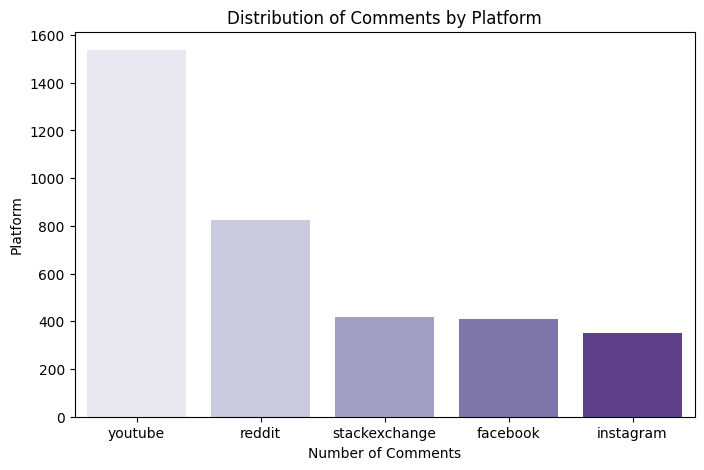

In [25]:
# Plotting comment distribution by platform
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='platform', order=df['platform'].value_counts().index, palette='Purples')
plt.title('Distribution of Comments by Platform')
plt.xlabel('Number of Comments')
plt.ylabel('Platform')
plt.show()

<ipython-input-46-d29850380d71>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['word_len'], bins=50, kde=True, palette='Purples')


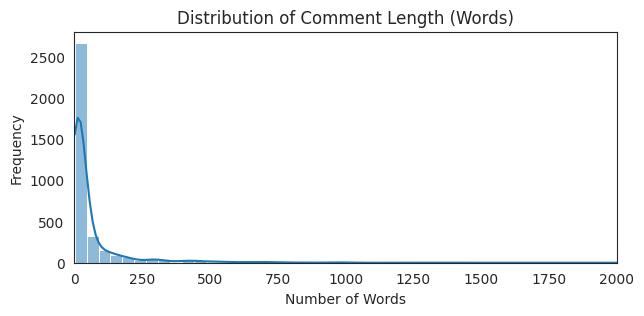

In [46]:
plt.figure(figsize=(7,3))
sns.histplot(df['word_len'], bins=50, kde=True, palette='Purples')
plt.title('Distribution of Comment Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 2000)
plt.show()

<ipython-input-45-aef178b39a15>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='platform', y='word_len', palette='Purples')


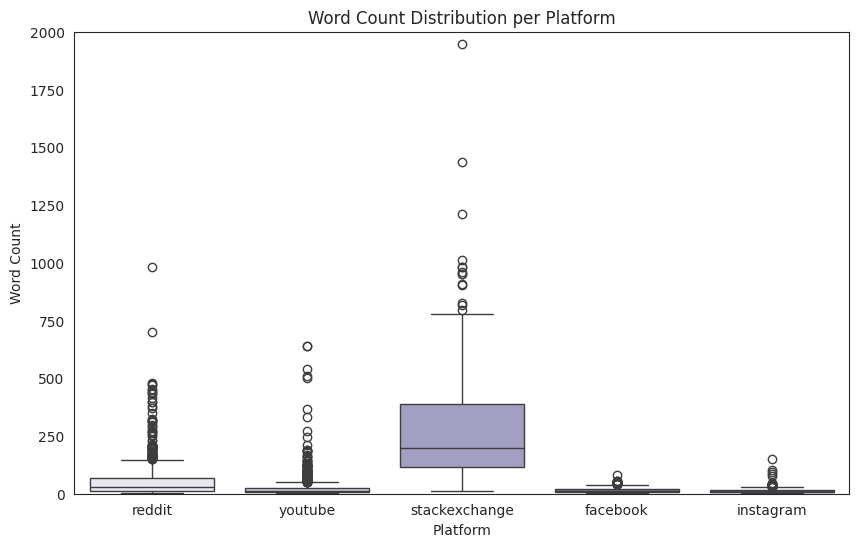

In [ ]:
#Word Count per Platform boxplot

plt.figure(figsize=(7, 3))
sns.boxplot(data=df, x='platform', y='word_len', palette='Purples')
plt.title('Word Count Distribution per Platform')
plt.xlabel('Platform')
plt.ylabel('Word Count')
plt.ylim(0, 2000) 
plt.show()

In [47]:
# Summary statistics for word and character lengths
df[['word_len', 'char_len']].describe()

,word_len,char_len
count,3539.000000,3539.000000
mean,59.294999,334.406329
std,129.626430,728.002626
min,1.000000,3.000000
25%,8.000000,43.000000
50%,17.000000,90.000000
75%,43.000000,248.500000
max,2201.000000,11178.000000
